In [88]:
# merge_all.csv 파일을 사용하여 "가격 (원)" 컬럼의 값을 예측하는 모델을 만든다

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# import XGBRegressor
from xgboost import XGBRegressor
# import GridSearchCV
from sklearn.model_selection import GridSearchCV
# import mean_absolute_error
from sklearn.metrics import mean_absolute_error
# import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score

from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv1D

# load model
from keras.models import load_model

# pickle
import pickle

# import datatime
from datetime import datetime

# import rc
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# mtick
import matplotlib.ticker as mtick

In [58]:
# 데이터 불러오기
df = pd.read_csv('data/merge_all/merge_drop.csv')
df.head()

# 데이터 전처리
# "거래년월일" 컬럼을 인덱스로 설정
df = df.set_index('거래년월일')
# "평균" 컬럼을 배추가격으로 설정
df = df.rename(columns={'평균':'배추가격'})
df.head()

,자동차용 경유 가격 (원),전월비(%),배추가격,거래량
거래년월일,,,,
2000-01-03,583.35,4.0,5600.0,102285.0
2000-01-04,583.35,4.0,5600.0,715338.0
2000-01-05,583.35,4.0,5620.0,340568.0
2000-01-06,583.35,4.0,5700.0,290180.0
2000-01-07,583.35,4.0,5670.0,536736.0


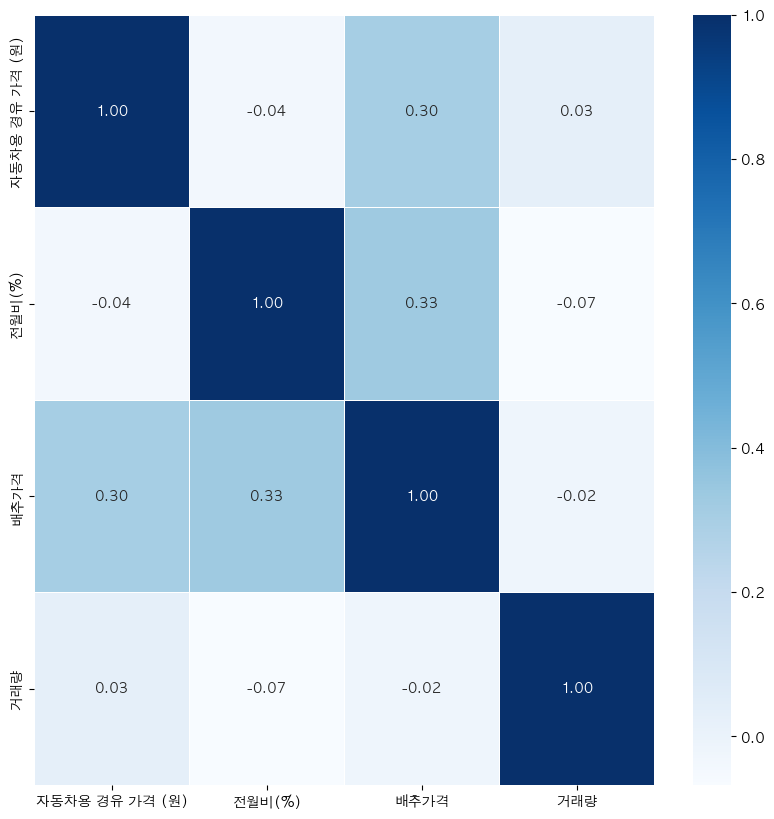

In [59]:
#  상관관계 분석
# 상관관계 분석을 위해 데이터 타입을 float로 변경
df = df.astype('float')

# 상관관계 분석
df.corr()



# 상관관계 시각화
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')
plt.show()



In [60]:
# "배추가격"의 이동평균을 함수로 만든다
def make_ma(df, col, ma_list):
    for ma in ma_list:
        df[col + '_' + str(ma) + 'MA'] = df[col].rolling(window=ma).mean()
    return df

# "배추가격"의 이동평균을 구한다
df = make_ma(df, '배추가격', [5, 20, 60, 300])

# "배추가격_N" 컬럼의 결측치를 제거한다
df = df.dropna()
df

,자동차용 경유 가격 (원),전월비(%),배추가격,거래량,배추가격_5MA,배추가격_20MA,배추가격_60MA,배추가격_300MA
거래년월일,,,,,,,,
2001-01-10,660.99,8.2,1900.0,219024.0,1904.0,1826.500,2088.683333,4683.080000
2001-01-11,660.99,8.2,1900.0,285105.0,1912.0,1823.000,2062.933333,4670.746667
2001-01-12,660.99,8.2,1900.0,114353.0,1924.0,1824.000,2040.266667,4658.413333
2001-01-13,660.99,8.2,1900.0,345429.0,1908.0,1829.500,2020.933333,4646.013333
2001-01-15,660.99,8.2,2040.0,86106.0,1928.0,1844.000,2004.850000,4633.813333
...,...,...,...,...,...,...,...,...
2022-11-24,1879.15,-8.0,6100.0,714993.0,6355.6,6908.150,17505.050000,11937.081667
2022-11-25,1879.15,-8.0,6100.0,1079776.0,6172.0,6817.350,17234.383333,11924.265000
2022-11-28,1879.15,-8.0,5664.0,201478.0,6044.8,6710.925,16932.116667,11910.411667


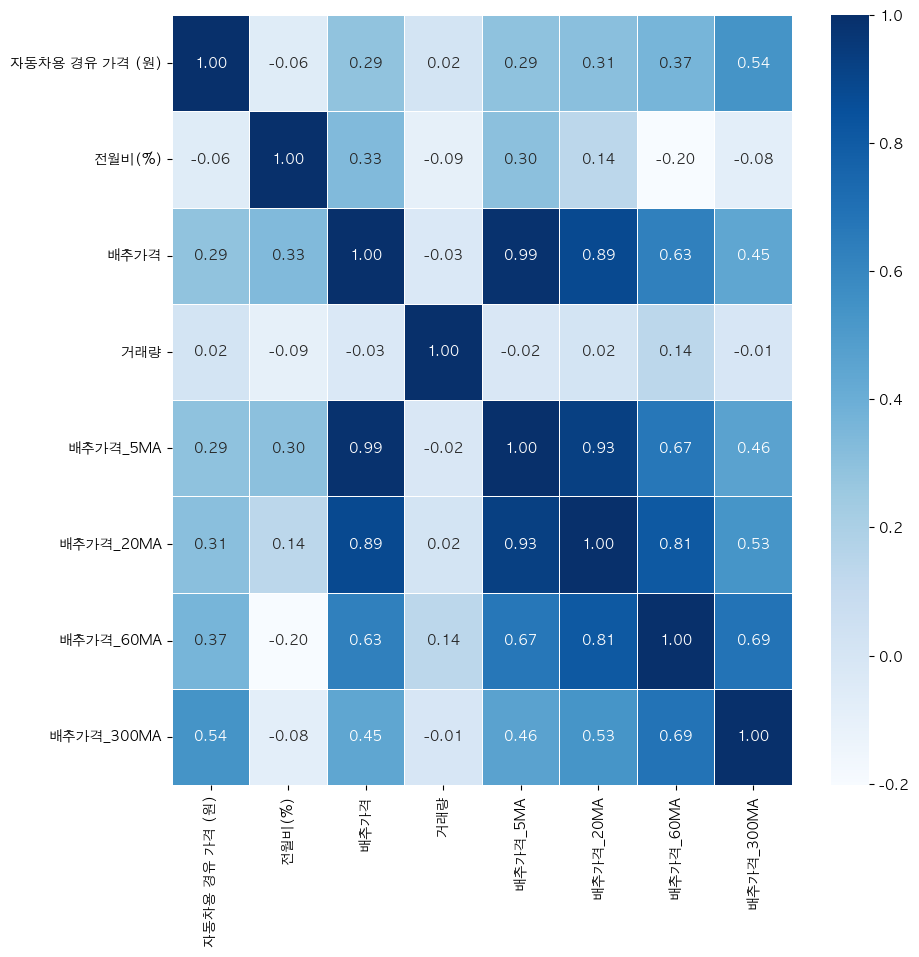

In [62]:
# 상관관계 분석
df.corr()

# 상관관계 시각화
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')
plt.show()


In [63]:
# "거래량" 컬럼 삭제
df = df.drop('거래량', axis=1)
df.head()

,자동차용 경유 가격 (원),전월비(%),배추가격,배추가격_5MA,배추가격_20MA,배추가격_60MA,배추가격_300MA
거래년월일,,,,,,,
2001-01-10,660.99,8.2,1900.0,1904.0,1826.5,2088.683333,4683.080000
2001-01-11,660.99,8.2,1900.0,1912.0,1823.0,2062.933333,4670.746667
2001-01-12,660.99,8.2,1900.0,1924.0,1824.0,2040.266667,4658.413333
2001-01-13,660.99,8.2,1900.0,1908.0,1829.5,2020.933333,4646.013333
2001-01-15,660.99,8.2,2040.0,1928.0,1844.0,2004.850000,4633.813333


In [64]:
# 2022-11-01 을 기준으로 df를 나눈다
df_train = df[df.index < '2022-11-01']
df_test = df[df.index >= '2022-11-01']

In [65]:
# "배추가격" 이외에 컬럼을 사용하여 "배추가격" 컬럼을 예측한다
# "배추가격_N" 컬럼을 X, "배추가격" 컬럼을 y로 설정한다
X_train = df_train.drop('배추가격', axis=1)
y_train = df_train['배추가격']
X_test = df_test.drop('배추가격', axis=1)
y_test = df_test['배추가격']


In [66]:
#  데이터 전처리
# 데이터를 0과 1사이의 값으로 변환한다
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [67]:
#find best params for XGBoost ,XGBoost 모델을 만든다
xgb = XGBRegressor()

# XGBoost 모델의 하이퍼파라미터를 설정한다
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.5, 0.7, 1],
    'subsample': [0.5, 0.7, 1],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0, 0.01, 0.1]
}

# XGBoost 모델의 하이퍼파라미터를 최적화한다
grid_cv = GridSearchCV(xgb, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(X_train, y_train)

# 최적의 하이퍼파라미터를 출력한다
print('최적의 하이퍼파라미터:', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적의 하이퍼파라미터: {'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.5}
최고 예측 정확도: 0.9665


In [68]:
# 최적의 하이퍼파라미터를 사용하여 XGBoost 모델을 만든다
xgb = XGBRegressor(n_estimators=grid_cv.best_params_['n_estimators'],
                  learning_rate=grid_cv.best_params_['learning_rate'],   
                  max_depth=grid_cv.best_params_['max_depth'],
                  colsample_bytree=grid_cv.best_params_['colsample_bytree'],
                  subsample=grid_cv.best_params_['subsample'],
                  reg_alpha=grid_cv.best_params_['reg_alpha'],
                  reg_lambda=grid_cv.best_params_['reg_lambda'])

# XGBoost 모델을 학습한다
xgb.fit(X_train, y_train)

# XGBoost 모델을 평가한다
y_pred = xgb.predict(X_test)
print('XGBoost 모델의 RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))


XGBoost 모델의 RMSE: 447.3688895277977


In [70]:
# 모델 저장
# 모델을 저장한다 model/
pickle.dump(xgb, open('model/xgb.pkl', 'wb'))

In [93]:
# 예측 성능 평가 지표를 출력한다
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2:', r2_score(y_test, y_pred))

MAE: 350.48879172585225
MSE: 200138.92331733488
RMSE: 447.3688895277977
R2: 0.42944098499334404


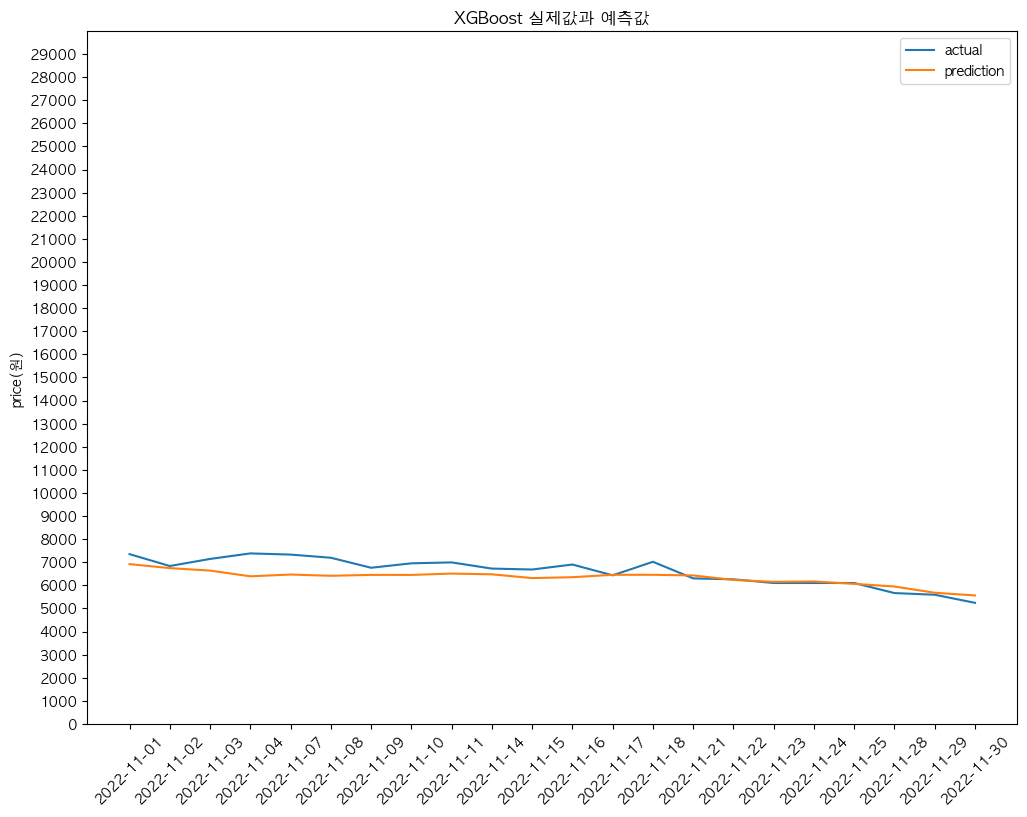

In [92]:

# XGBoost 모델의 예측 결과를 시각화한다 
plt.figure(figsize=(12, 9))
plt.plot(y_test, label='actual')
# 글자가 겹치지 않도록 회전한다
plt.xticks(rotation=45)
plt.plot(y_pred, label='prediction')
plt.title('XGBoost 실제값과 예측값')
# y축의 범위를 0과 40000 사이로 설정한다
plt.ylim(0, 30000)
# y축의 눈금을 0부터 40000까지 1000 단위로 설정한다
plt.yticks(np.arange(0, 30000, 1000))
# y축 눈금 라벨을 원 단위로 설정한다
plt.ylabel('price(원)')
plt.legend()
plt.show()

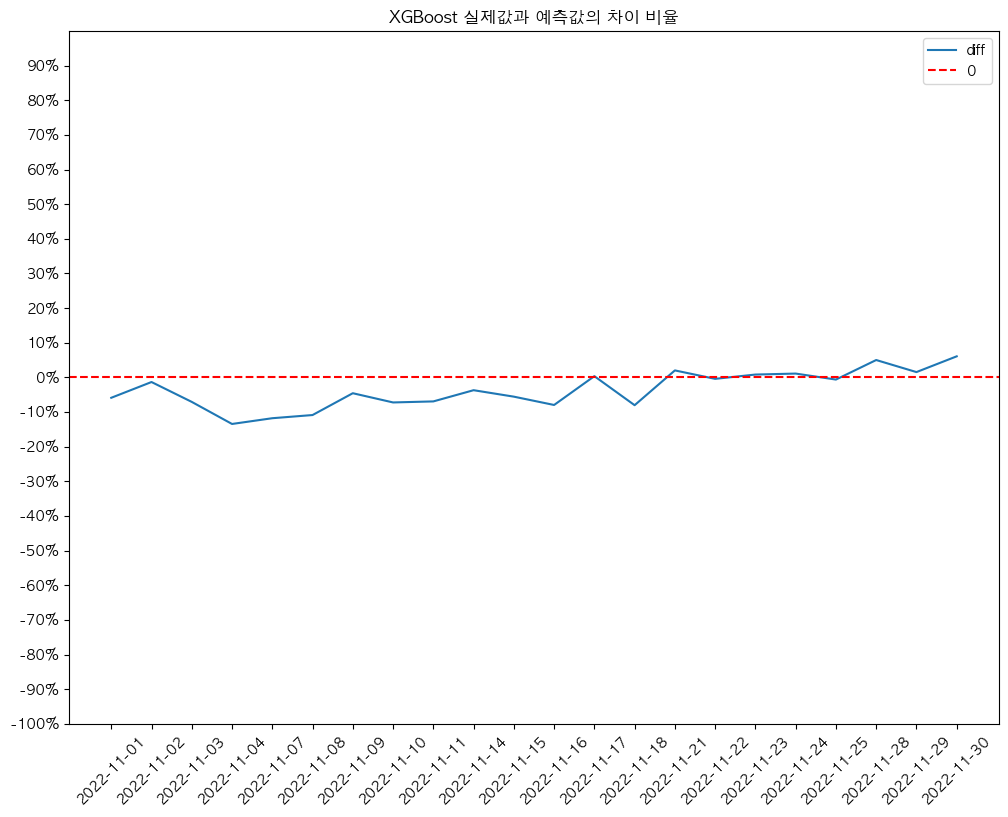

In [90]:
# 예측값 성능 평가
# 예측값과 실제값의 차이를 비율로 계산한다
diff = (y_pred - y_test) / y_test * 100
diff = diff.dropna()

# 예측값과 실제값의 차이를 시각화한다,
plt.figure(figsize=(12, 9))
# y축의 범위를 -10과 10 사이로 설정한다
plt.ylim(-100, 100)
# y축의 눈금을 -10부터 10까지 2간격으로 설정한다
plt.yticks(np.arange(-100, 100, 10))
# y축 눈금에 %를 붙인다
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
# 글자가 겹치지 않도록 회전한다
plt.xticks(rotation=45)
plt.plot(diff)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('XGBoost 실제값과 예측값의 차이 비율')
# 범례를 표시한다
plt.legend(['diff', '0'])
plt.show()